<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Краткий вывод</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовим-признаки" data-toc-modified-id="Подготовим-признаки-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Подготовим признаки</a></span></li></ul></li></ul></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Краткий вывод</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Краткий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import optuna
from optuna.samplers import TPESampler
import os
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Seed
RS = 3456554 #RandomSeed

# Params

plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
pth1 = 'D:\Temp\Ya_Pr\taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif not os.path.exists(pth1):
    data = pd.read_csv('https://code.s3.yandex.net//datasets//taxi.csv', index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data = data.resample('1H').sum()
data.sort_index(inplace=True)

In [5]:
data.index.is_monotonic

True

## Анализ

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


После ресемплирования по часам получили датасет из 4416 строк.

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


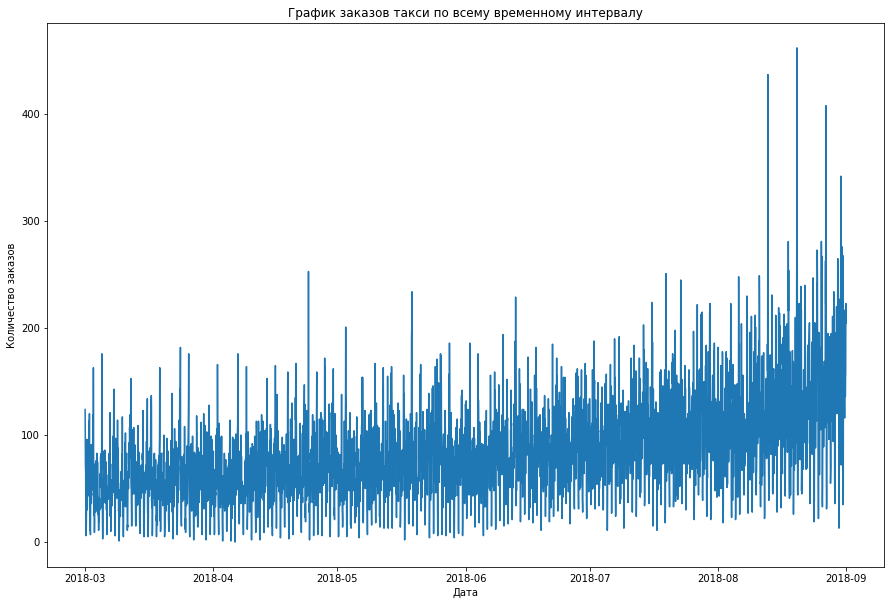

In [8]:
plt.plot(data)
#plt.plot(data.rolling(7).mean(), color='orange')
plt.title('График заказов такси по всему временному интервалу')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

In [9]:
print(f'Начало отсчета: {data.index.min()}')

print(f'Конец отсчета: {data.index.max()}')

Начало отсчета: 2018-03-01 00:00:00
Конец отсчета: 2018-08-31 23:00:00


Выделим тренд и сезонность.

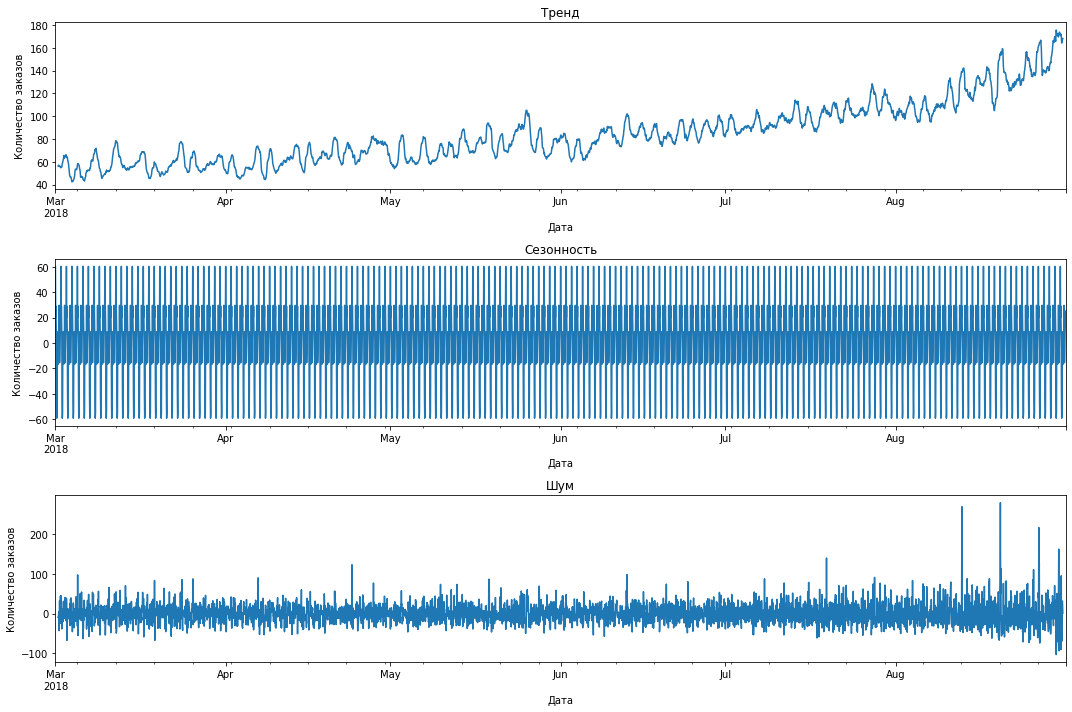

In [10]:
decomp = seasonal_decompose(data) 

#plt.figure(figsize=(15, 10))
plt.subplot(311)

decomp.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)


decomp.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomp.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

Сезонность не очень выразительно выглядит. Посмотрим за один месяц

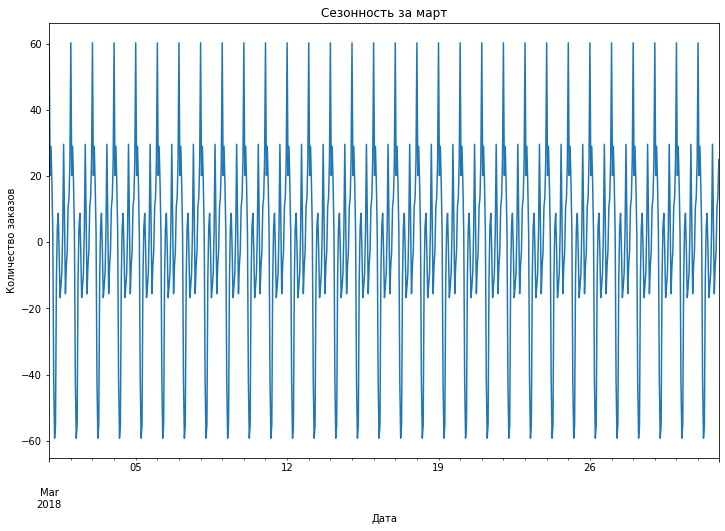

In [11]:
decomp.seasonal[:31*24].plot(figsize=(12, 8)) #31 день по 24 часа
plt.title('Сезонность за март')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

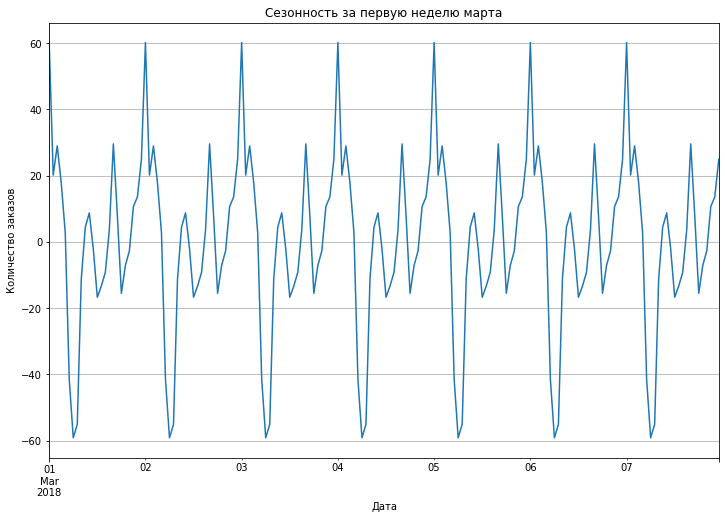

In [12]:
decomp.seasonal[:7*24].plot(figsize=(12, 8), grid=True) #1 неделя по 24 часа
plt.title('Сезонность за первую неделю марта')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

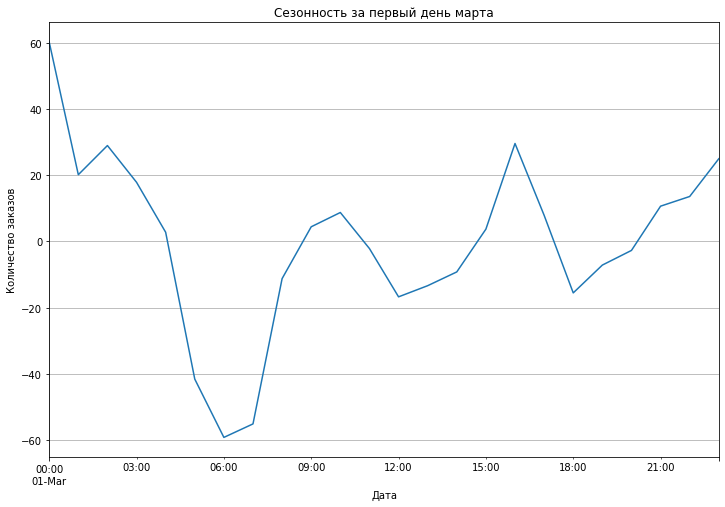

In [13]:
decomp.seasonal[:1*24].plot(figsize=(12, 8), grid=True) #1 неделя по 24 часа
plt.title('Сезонность за первый день марта')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Как видно из графика, с полуночи до утра количество заказов падает, далее растет до часа пик (около 9 утра), далее небольшой спад и последующий рост к вечеренму часу пик (около 16 часов)

Нулевая гипотеза: процесс нестационарный  
Альтернативная гипотеза: процесс стационарный

Уровень значимости определим в 0,05 и в 0,01

In [14]:
from statsmodels.tsa.stattools import adfuller
 
adf_test = adfuller(data)
 
print('ADF статистика:', adf_test[0])
print('p-значение:', adf_test[1])
print('Критические значения:')
for key, value in adf_test[4].items():
    print(f'  {key}: {value}')


print('-'*25)
print('alpha = 0,05')
if adf_test[0] < adf_test[4]['5%']:
    print ('Нулевая гипотеза отвергнута — Временной ряд стационарен')
else:
    print ('Нулевая гипотеза не отвергнута — Временной ряд не стационарен')

print('-'*25)
print('alpha = 0,01')
if adf_test[0] < adf_test[4]['1%']:
    print ('Нулевая гипотеза отвергнута — Временной ряд стационарен')
else:
    print ('Нулевая гипотеза не отвергнута — Временной ряд не стационарен')

ADF статистика: -3.0689242890279536
p-значение: 0.028940051402613094
Критические значения:
  1%: -3.431842162413052
  5%: -2.8621993540813637
  10%: -2.567120978470452
-------------------------
alpha = 0,05
Нулевая гипотеза отвергнута — Временной ряд стационарен
-------------------------
alpha = 0,01
Нулевая гипотеза не отвергнута — Временной ряд не стационарен


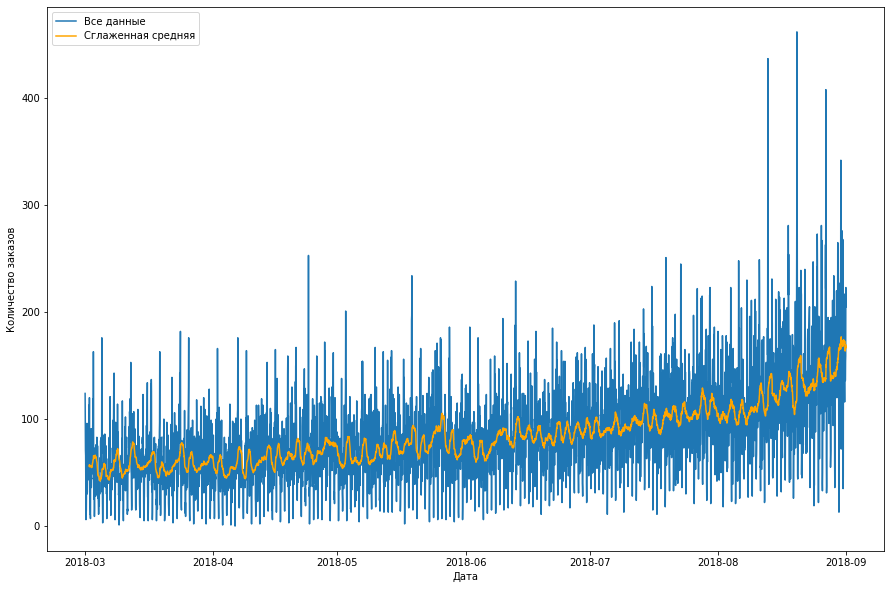

In [15]:
# Сглаженная средняя
plt.plot(data, label='Все данные')

plt.plot(data.shift().rolling(24).mean(), color='orange', label='Сглаженная средняя')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()

plt.show()

Сглаженное среднее увеличивается со временем, значит, ряд нестационарен, что подтверждает тест Дики — Фулера.

## Краткий вывод

Датасет ресемплирован до 1 часа. Данные выстроены в хронологическом порядке.

По исследованию датасета выявлено:
* Данные представлены за период с марта по август 2018 года, т.е. за ~5 месяцев;
* По трендам видно увеличение пользования сервисом на всем промежутке данных;
* Сезонность имеет суточный характер - днем больше заказов, ночью меньше. Также обнаружены всплески около часов пик.



## Обучение

#### Подготовим признаки

In [16]:
def features_maker(dataframe, rolling_size, max_lag):
    """"
    Return dataframe with new features
    """
    df = dataframe.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['week_day'] = df.index.dayofweek
    df['is_weekend'] = np.where(df['week_day'].isin([5, 6]), 1, 0)
    df['r_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()

    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    return df


In [17]:
def cross_val_timeline(X_train, y_train, model):
    """"
    Return cross-validated mean RMSE for features and target
    """
    scores = 0
    i = 1
    tscv = TimeSeriesSplit(n_splits=5, gap=int(X_train.shape[0] / 10))
    for train_index, test_index in tscv.split(X_train):
        try:
            X_time_train, X_time_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_time_train, y_time_test = y_train.iloc[train_index], y_train.iloc[test_index]
        except:
            X_time_train, X_time_test = X_train[train_index], X_train[test_index]
            y_time_train, y_time_test = y_train[train_index], y_train[test_index]

        model.fit(X_time_train, y_time_train)

        predictions = model.predict(X_time_test)
        rmse = np.sqrt(mean_squared_error(y_time_test, predictions))

        scores += rmse
        i += 1

    cr_val_rmse = scores / i

    return cr_val_rmse

In [18]:
def best_feature_size(dataframe, rolling_size, max_lag):
    rolls = []
    lags = []
    rmse = []
    for roll in range(2, rolling_size+1):
        for lag in range(1, max_lag+1):
            data_for_model = features_maker(dataframe, roll, lag)

            X = data_for_model.drop('num_orders', axis=1)
            y = data_for_model['num_orders']

            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                train_size=.9, 
                shuffle=False, 
                random_state=RS
            )



            X_train = X_train.dropna()
            X_test = X_test.dropna()

            y_train = y_train[X_train.index]
            y_test = y_test[X_test.index]


            model = LinearRegression(n_jobs=-1)


            cr_val_rmse = cross_val_timeline(X_train, y_train, model)

            
            rolls.append(roll)
            lags.append(lag)
            rmse.append(cr_val_rmse)

    result = pd.DataFrame(data=list(zip(rolls, lags, rmse)), columns=['rolling_size', 'max_lag', 'rmse'])

    return result

In [19]:
t = best_feature_size(data, 24, 200)

In [20]:
t.sort_values(by='rmse')

,rolling_size,max_lag,rmse
4071,22,72,20.599369
3072,17,73,20.600134
3071,17,72,20.600213
3671,20,72,20.601551
271,3,72,20.602176
...,...,...,...
1999,11,200,36.596754
3785,20,186,37.319257
1396,8,197,37.914392
1794,10,195,42.105555


По результатам подбора количества признаков для модели оптимальный результат:
* размер окна скользящего среднего — 17;
* лаг — 73.

In [21]:
data_for_model = features_maker(data, 4, 198)

X = data_for_model.drop('num_orders', axis=1)
y = data_for_model['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=.9, 
    shuffle=False, 
    random_state=RS
)



X_train = X_train.dropna()
X_test = X_test.dropna()

y_train = y_train[X_train.index]
y_test = y_test[X_test.index]


print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (3776, 203)
y_train: (3776,)
X_test: (442, 203)
y_test: (442,)


Подготовим данные для теста различных моделей машинного обучения.



In [22]:
num_imputer = SimpleImputer(strategy='median')

In [23]:
std_scaler = StandardScaler()


X_train_transformed = std_scaler.fit_transform(X_train)
X_test_transformed = std_scaler.transform(X_test)

In [24]:
print(f'X_train_transformed: {X_train_transformed.shape}')
print()
print(f'X_test_transformed: {X_test_transformed.shape}')


X_train_transformed: (3776, 203)

X_test_transformed: (442, 203)


Будем использовать случайный лес, LightGBM и CatBoost.

In [25]:
# Функция подбора гиперпараметров RandomForest

def objective_RF(trial):
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'])
    bootstrap = trial.suggest_categorical('bootstrap',[True, False])
    max_depth = trial.suggest_int('max_depth', 1, 10000)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000)
    
    model = RandomForestRegressor(random_state=RS,
                                        bootstrap = bootstrap, 
                                        criterion = criterion,
                                        max_depth = max_depth, 
                                        max_features = max_features,
                                        max_leaf_nodes = max_leaf_nodes,
                                        n_estimators=n_estimators,
                                        n_jobs=-1)
    
    
    
    
    #model.fit(X_train_transformed, y_train)
    #scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    #rmse = np.sqrt(abs(scores.mean()))

    cr_val_rmse = cross_val_timeline(X_train_transformed, y_train, model)
    
    return cr_val_rmse

In [26]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

study_RF = optuna.create_study(study_name="RandomForest", direction="minimize", sampler=sampler)
study_RF.optimize(objective_RF, n_trials=100)

In [27]:
print('Number of finished trials: ', len(study_RF.trials))
print('Best trial:')
trial = study_RF.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  20.951488744169207
  Params: 
    criterion: absolute_error
    bootstrap: False
    max_depth: 9992
    max_features: sqrt
    max_leaf_nodes: 2455
    n_estimators: 772


In [28]:
best_RMSE_RF = trial.value

In [29]:
# Функция подбора гиперпараметров LightGBM

def objective_LGBM(trial):
    params = {
        # Hyperparameter settings
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 6, 306, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 1000, step=50),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.95),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0.1, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0.1, 100, step=1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
        
    }
    
    model = LGBMRegressor(**params, n_jobs=-1, random_state=RS, verbose=-1)  
    
    #model.fit(X_train_transformed, y_train)
    #preds = model.predict(X_test_transformed)
    #scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #rmse = np.sqrt(abs(scores).mean())

    cr_val_rmse = cross_val_timeline(X_train_transformed, y_train, model)
    
    return cr_val_rmse

In [30]:
study_LGBM = optuna.create_study(study_name="LightGBM", direction="minimize", sampler=sampler)
study_LGBM.optimize(objective_LGBM, n_trials=100)

In [31]:
print('Number of finished trials: ', len(study_LGBM.trials))
print('Best trial:')
trial = study_LGBM.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  22.72390881402539
  Params: 
    n_estimators: 700
    learning_rate: 0.33987285563946773
    num_leaves: 26
    max_depth: 7
    min_data_in_leaf: 200
    min_gain_to_split: 11.825084933127735
    bagging_fraction: 0.9476461454965255
    max_bin: 295
    lambda_l1: 100
    lambda_l2: 74
    bagging_freq: 1
    feature_fraction: 0.7446787278579067


In [32]:
best_RMSE_LGBM = trial.value

In [33]:
def objective_CB_enc(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 400, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 10),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    

    model = CatBoostRegressor(**params, 
                              random_state=RS, 
                              loss_function='RMSE', 
                              verbose=False
    )

    #model.fit(X_train_transformed, y_train)
    
    #preds = model.predict(X_test_transformed)
    #scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #rmse = np.sqrt(abs(scores).mean())

    cr_val_rmse = cross_val_timeline(X_train_transformed, y_train, model)
    
    return cr_val_rmse


In [34]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="minimize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, n_trials=100)

In [35]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  18.934602175998904
  Params: 
    iterations: 719
    learning_rate: 0.02434892619968468
    depth: 4
    l2_leaf_reg: 0.057953479927238524
    bootstrap_type: Bayesian
    random_strength: 0.0055067571269555035
    bagging_temperature: 1.857283104168303
    od_type: IncToDec
    od_wait: 38


In [36]:
best_RMSE_CB = trial.value

Сведем все оценки в табличку и определим лучшую модель.

In [37]:
pd.DataFrame([best_RMSE_RF, best_RMSE_LGBM, best_RMSE_CB], columns=['RMSE'], index=['RandomForest', 'LightGBM', 'CatBoost'])

,RMSE
RandomForest,20.951489
LightGBM,22.723909
CatBoost,18.934602


## Краткий вывод

На основе данных подготовлены признаки для обучения моделей.

Вычислено оптимальное количество и размер признаков.

Датасет разбит на обучающую и тестовую выборки, данные масштабированы.

Обучены три модели машинного обучения - RandomForest, LightGBM и CatBoost.  
Для каждой из них подобраны оптимальные гиперпараметры.

С результатом RMSE 18,93 лучшей оказалась моделй CatBoost.

## Тестирование

Протестируем модель неа тестовой выборке.

In [38]:
model_CB_enc = CatBoostRegressor(**study_CB_enc.best_params, random_state=RS, verbose=False)

model_CB_enc.fit(X_train_transformed, y_train)

preds = model_CB_enc.predict(X_test_transformed)

print('RMSE on test:', np.sqrt(mean_squared_error(y_test, preds)))

RMSE on test: 35.55737027672625


RMSE = 35.55, что удовлетворяет условиям задачи

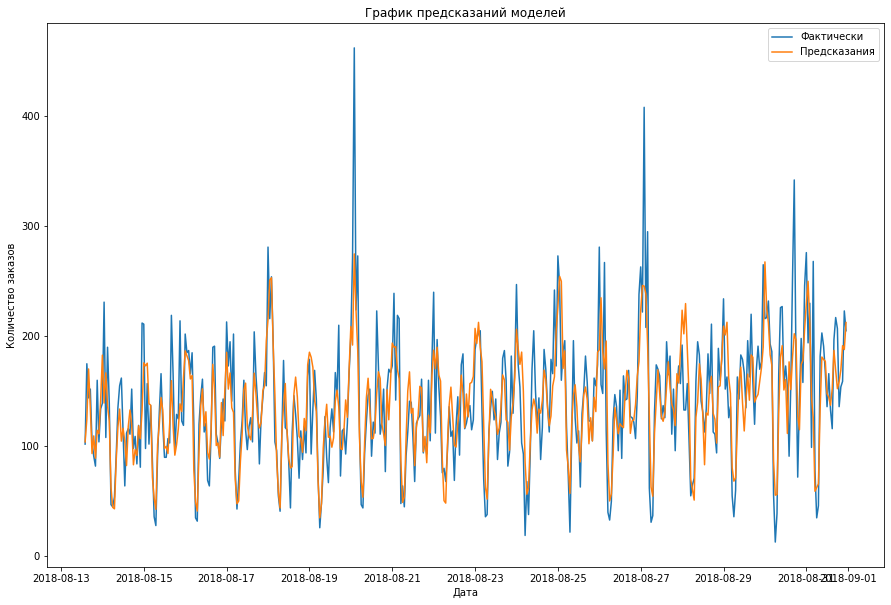

In [39]:
plt.figure(figsize=(15,10))

plt.plot(y_test, label='Фактически')
plt.plot(y_test.index, preds, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.title('График предсказаний моделей')
plt.legend()

plt.show()

Из графика видно, что модель в целом неплохо предсказывает, но не "дотягивает" на резких пиках и на последних датах.

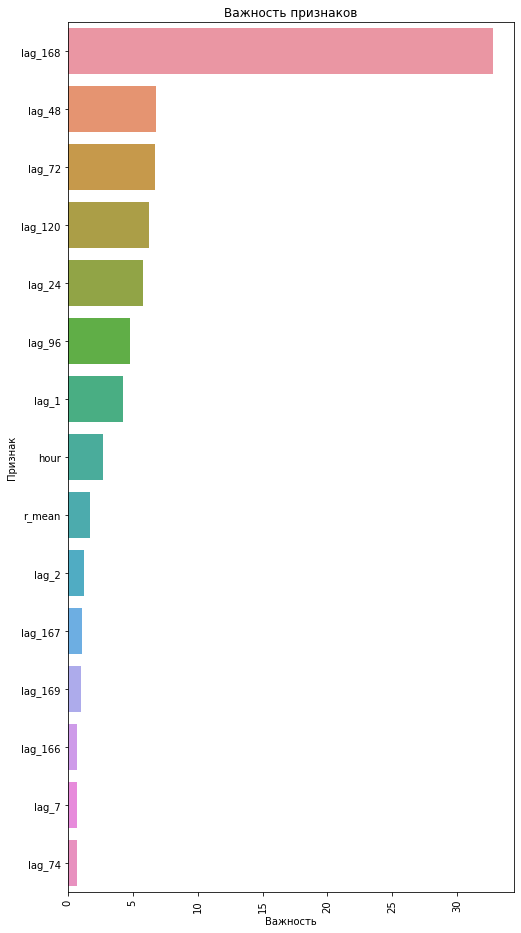

In [40]:
feature_imp = pd.Series(model_CB_enc.feature_importances_, index=list(X_test.columns)).sort_values(ascending=False)


plt.figure(figsize=(8, 16))

sns.barplot(y=list(feature_imp.index)[:15], x=feature_imp.values[:15], orient='h')

plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.xticks(rotation= 90)

plt.show()

Заметим, что важные признаки кратны 24. Это подтвержает суточный характер сезонности.

In [41]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(X_train_transformed, y_train)

dummy_preds = dummy_regr.predict(X_test_transformed)

print('RMSE on test', np.sqrt(mean_squared_error(y_test, dummy_preds)))

RMSE on test 83.88821967964161


Метрика константной модели заметно выше, чем лучшей отобранной, значит, наша модель предсказывает лучше и имеет право на существование.

## Краткий вывод

Выбранная лучшая модель (CatBoost) проверена на тестовой выборке. 

Результат (RMSE = 35.84) удовлетворяет требованиям поставленной задачи.

Построен график для сравнения предсказаний и фактических значений, оценена важность признаков.

Модель сравнена с константной моделью - и показала себя лучше, что говорит о ее праве на существование.

# Вывод

Искомые данные - данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Датасет ресемплирован до 1 часа. Данные выстроены в хронологическом порядке.

По исследованию датасета выявлено:
* Данные представлены за период с марта по август 2018 года, т.е. за ~5 месяцев;
* По трендам видно увеличение пользования сервисом на всем промежутке данных;
* Сезонность имеет суточный характер - днем больше заказов, ночью меньше. Также обнаружены всплески около часов пик.

На основе исходных данных подготовлены признаки для обучения моделей.

Вычислено оптимальное количество и размер признаков.

Датасет разбит на обучающую и тестовую выборки, данные масштабированы.

Обучены три модели машинного обучения - RandomForest, LightGBM и CatBoost.  
Для каждой из них подобраны оптимальные гиперпараметры.

В целом все модели проходят необходимы порог по метрике (не более 48).

С результатом RMSE = 35.84 лучшей оказалась моделй CatBoost.